<a href="https://colab.research.google.com/github/yash-garg274/Music-Generation-VAE/blob/main/Music_Gen_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import librosa

In [ ]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, InputLayer
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [ ]:
train_size = 60000
BATCH_SIZE = 8
test_size = 10000
epochs = 50
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 2
BASE_PATH = '/content/drive/MyDrive/Data/genres_original'


In [ ]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    train_music_1 = list(music_list[[0,52,19,39,71,12,75,85,3,45,24,46,88]]) #99,10,66,76,41
    train_music_2 = list(music_list[[4,43,56,55,45,31,11,13,70,37,21,78]]) #65,32,53,22,19,80,89,
    TrackSet_1 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_1]
    TrackSet_2 = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music_2]

    return TrackSet_1, TrackSet_2

In [ ]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [ ]:
TrackSet_1, TrackSet_2 = DatasetLoader('jazz')

In [ ]:
sample = TrackSet_1[1]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)


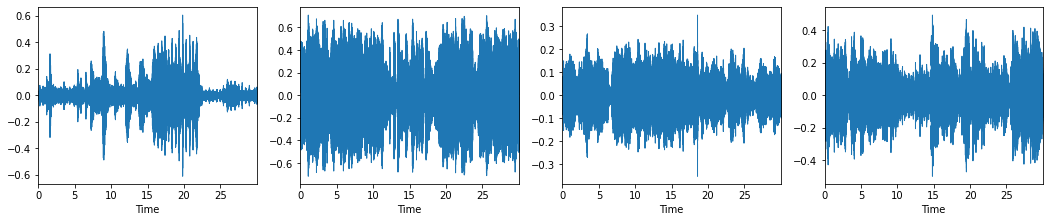

In [ ]:
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveplot(j[0], sr=3000)

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

In [ ]:
class ResnetBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters,type='encode'):
        super(ResnetBlock, self).__init__()
    
        if type=='encode':
            self.conv1a = Conv1D(filters, kernel_size, 2,padding="same")
            self.conv1b = Conv1D(filters, kernel_size, 1,padding="same")
            self.norm1a = tfa.layers.InstanceNormalization()
            self.norm1b = tfa.layers.InstanceNormalization()
        if type=='decode':
            self.conv1a = Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.conv1b = Conv1DTranspose(filters, kernel_size, 1,padding="same")
            self.norm1a = BatchNormalization()
            self.norm1b = BatchNormalization()
        else:
            return None
    def call(self, input_tensor):
          x = tf.nn.relu(input_tensor)
          x = self.conv1a(x)
          x = self.norm1a(x)
          x = LeakyReLU(0.4)(x)

          x = self.conv1b(x)
          x = self.norm1b(x)
          x = LeakyReLU(0.4)(x)

          x += input_tensor
          return tf.nn.relu(x)

In [ ]:
class VAE(tf.keras.Model):
    """Variational Autoencoder."""

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                InputLayer(input_shape=(1,90001)),
                Conv1D(64,1,2),
                ResnetBlock(64,1),
                Conv1D(128,1,2),
                ResnetBlock(128,1),
                Conv1D(128,1,2),
                ResnetBlock(128,1),
                Conv1D(256,1,2),
                ResnetBlock(256,1),
                # No activation
                Flatten(),
                Dense(latent_dim+latent_dim)

            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                InputLayer(input_shape=(latent_dim,)),
                Reshape(target_shape=(1,latent_dim)),
                ResnetBlock(512,1,'decode'),
                Conv1DTranspose(512,1,1),
                ResnetBlock(256,1,'decode'),
                Conv1DTranspose(256,1,1),
                ResnetBlock(128,1,'decode'),
                Conv1DTranspose(128,1,1),
                ResnetBlock(64,1,'decode'),
                Conv1DTranspose(64,1,1),
                # No activation
                Conv1DTranspose(90001,1,1),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [ ]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [ ]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [ ]:
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim)

In [ ]:
import librosa.display
save_music=[]
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        if epoch>14:
            save_music.append(wave)
        librosa.display.waveplot(wave[0], sr=3000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('jazz_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

ParameterError: ignored

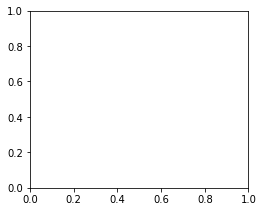

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_x = np.asarray(train_x)[0]
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        test_x = np.asarray(test_x)[0]
        loss(compute_loss(model, test_x))
    display.clear_output(wait=False)
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

In [ ]:
anim_file_1 = 'jazz_vae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('jazz*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


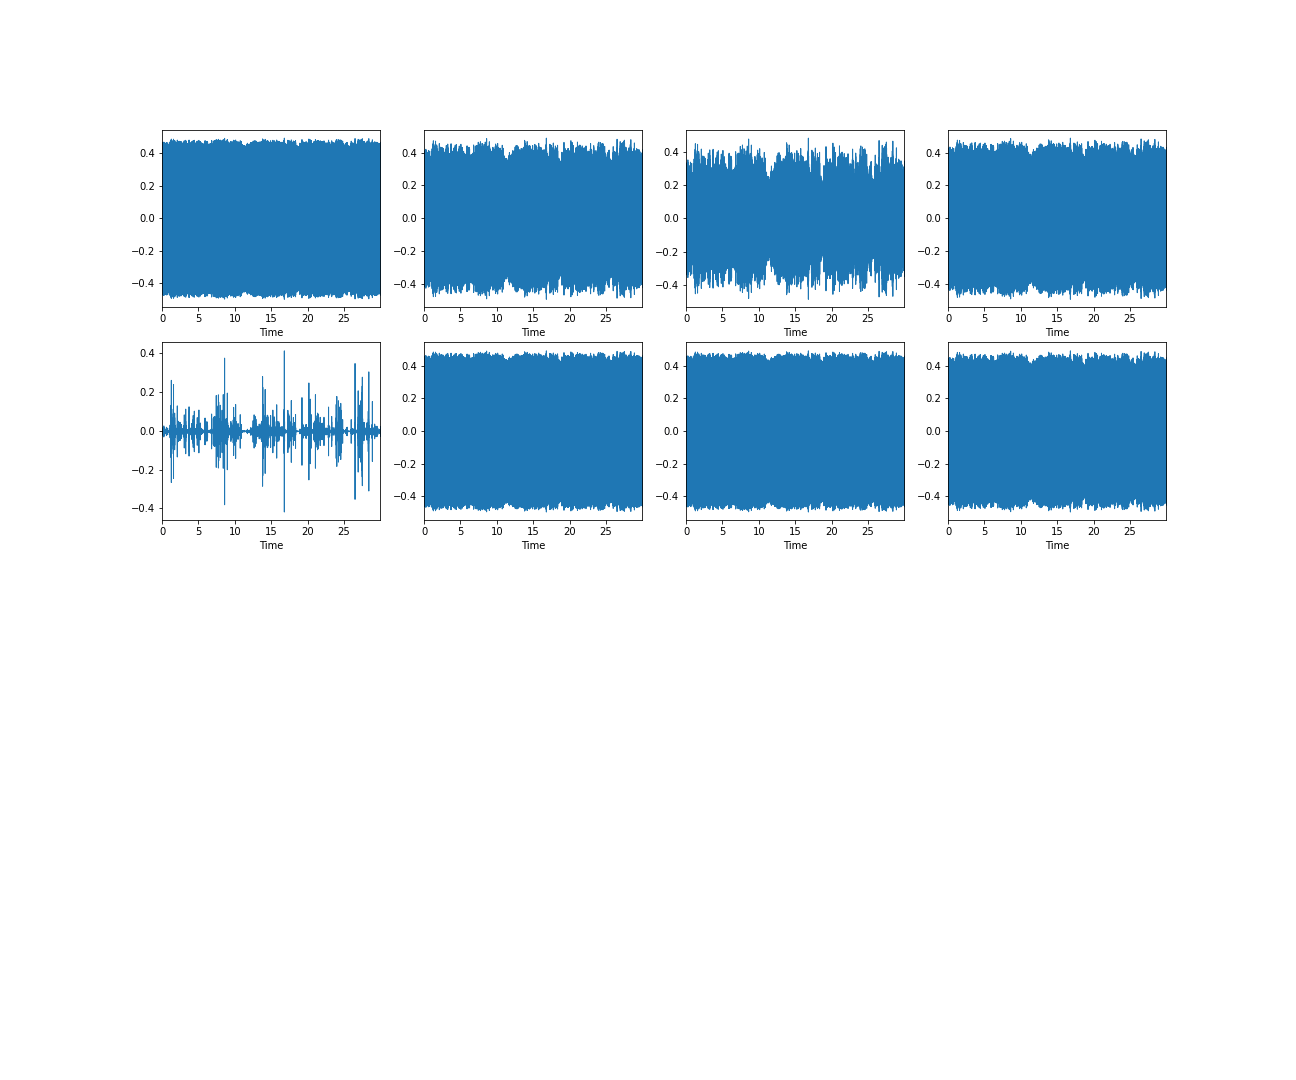

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)

In [ ]:
l1=save_music[13][0]
ipd.Audio(l1,rate=3000)